# ENV

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from einops import reduce, repeat, rearrange, einsum

# Data

In [ ]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

dataset = MNIST('.', download=True, transform=transforms.ToTensor())
dataloader = DataLoader(dataset,batch_size=32, shuffle=True, drop_last=True)

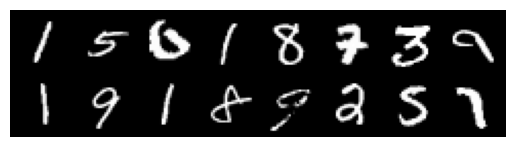

In [ ]:
from torchvision.utils import make_grid


def show_image(image, num_images, size=(1,28,28)):
    unflat_image = rearrange(image.detach().cpu(),'b (c h w) -> b c h w', c=size[0], h = size[1], w=size[2])
    image_grid  = make_grid(unflat_image[: num_images], nrow=8)
    plt.imshow(rearrange(image_grid, 'a b c -> b c a').squeeze())
    plt.axis('off')
    plt.show()

show_image(rearrange(next(iter(dataloader))[0], 'b c h w -> b (c h w)'),16)

# Architecture

In [ ]:
class GeneratorBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(input_dim, output_dim),
                                   nn.BatchNorm1d(output_dim),
                                   nn.ReLU(inplace=True))

    def forward(self, x):
        return self.layer(x)

x = torch.rand(16,128)
tmp=GeneratorBlock(128,256)
tmp(x).shape

torch.Size([16, 256])

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, hidden_dim, image_dim):
        super().__init__()
        self.gen = nn.Sequential(
            GeneratorBlock(z_dim, hidden_dim),
            GeneratorBlock(hidden_dim, 2*hidden_dim),
            GeneratorBlock(2*hidden_dim, 4*hidden_dim),
            GeneratorBlock(4*hidden_dim, 8*hidden_dim),
            nn.Linear(8*hidden_dim, image_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.gen(x)

x = torch.rand([16, 10])
tmp=Generator(10,100,128)
tmp(x).shape

torch.Size([16, 128])

In [ ]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(input_dim, output_dim),
                                   nn.LeakyReLU(negative_slope=0.2, inplace=True))

    def forward(self, x):
        return self.layer(x)

x= torch.rand([1,100])
tmp=DiscriminatorBlock(100,200)
tmp(x).shape

torch.Size([1, 200])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, image_dim, hidden_dim):
        super().__init__()
        self.disc = nn.Sequential(DiscriminatorBlock(image_dim, 4*hidden_dim),
                                  DiscriminatorBlock(4*hidden_dim, 2*hidden_dim),
                                  DiscriminatorBlock(2*hidden_dim, hidden_dim),
                                  nn.Linear(hidden_dim, 1))

    def forward(self,x):
        return self.disc(x)

x = torch.rand(1,100)
tmp=Discriminator(100, 10)
tmp(x).shape

torch.Size([1, 1])

# Training

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
z_dim = 64
batch_size = 8192*2
learning_rate = 1e-5

criterion = nn.BCEWithLogitsLoss()
dataloader = DataLoader(dataset,batch_size=batch_size, shuffle=True, drop_last=True)

gen = Generator(z_dim, 128, 784)
gen=gen.to(device)
gen_opt = torch.optim.Adam(gen.parameters(),lr=learning_rate)

disc= Discriminator(784,128)
disc=disc.to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=learning_rate)

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    noise = torch.rand(num_images, z_dim, device=device)
    fake = gen(noise).detach()

    pred_fake = disc(fake)
    fake_loss = criterion(pred_fake, torch.zeros_like(pred_fake,device=device))
    fake_acc = reduce(((pred_fake<0.5) == torch.zeros_like(pred_fake, device=device)).float(), 'b 1 -> ()', 'mean')

    pred_real = disc(real)
    real_loss = criterion(pred_real, torch.ones_like(pred_real, device=device))
    real_acc = reduce(((pred_real>=0.5) == torch.ones_like(pred_real, device=device)).float(), 'b 1 -> ()', 'mean')

    loss = (fake_loss+real_loss)/2
    acc = (fake_acc+real_acc)/2

    return loss, acc

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    noise = torch.rand((num_images, z_dim), device=device)
    fake = gen(noise)
    pred = disc(fake)
    loss = criterion(pred, torch.ones_like(pred, device=device))
    acc = reduce(((pred>=0.5) == torch.zeros_like(pred, device=device)).float(), 'b 1 -> ()', 'mean')
    return loss, acc

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/3 [00:00<?, ?it/s]

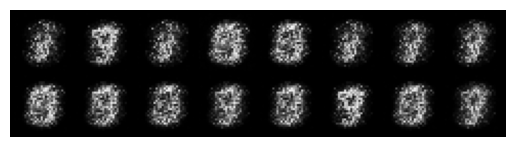

Epoch 2/200:   0%|          | 0/3 [00:00<?, ?it/s]

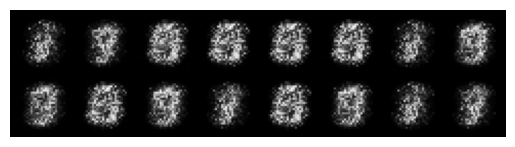

Epoch 3/200:   0%|          | 0/3 [00:00<?, ?it/s]

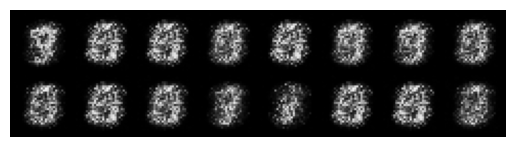

Epoch 4/200:   0%|          | 0/3 [00:00<?, ?it/s]

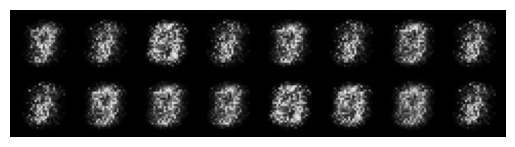

Epoch 5/200:   0%|          | 0/3 [00:00<?, ?it/s]

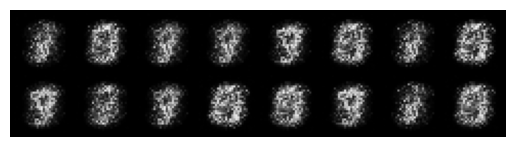

Epoch 6/200:   0%|          | 0/3 [00:00<?, ?it/s]

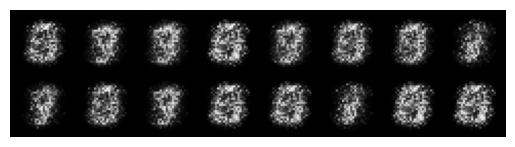

Epoch 7/200:   0%|          | 0/3 [00:00<?, ?it/s]

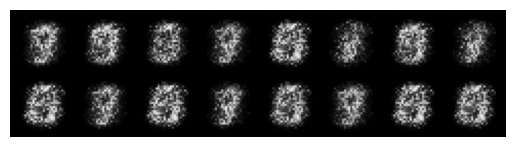

Epoch 8/200:   0%|          | 0/3 [00:00<?, ?it/s]

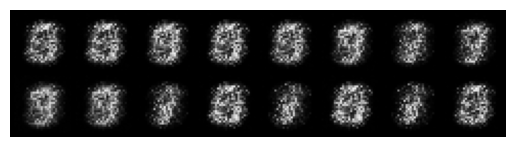

Epoch 9/200:   0%|          | 0/3 [00:00<?, ?it/s]

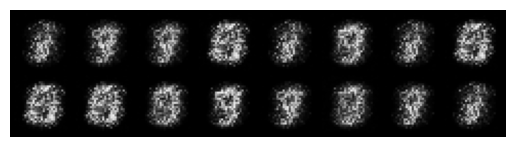

Epoch 10/200:   0%|          | 0/3 [00:00<?, ?it/s]

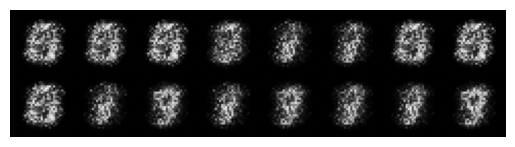

Epoch 11/200:   0%|          | 0/3 [00:00<?, ?it/s]

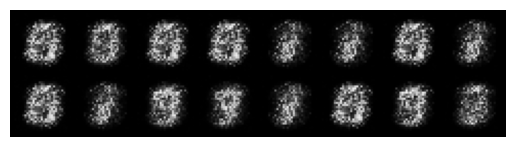

Epoch 12/200:   0%|          | 0/3 [00:00<?, ?it/s]

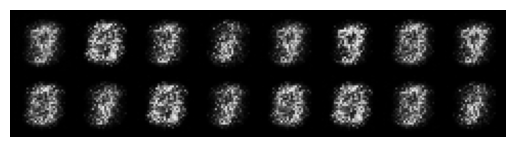

Epoch 13/200:   0%|          | 0/3 [00:00<?, ?it/s]

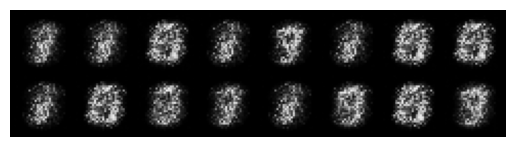

Epoch 14/200:   0%|          | 0/3 [00:00<?, ?it/s]

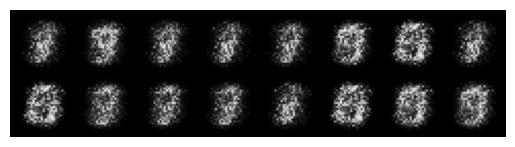

Epoch 15/200:   0%|          | 0/3 [00:00<?, ?it/s]

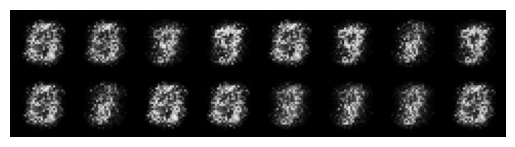

Epoch 16/200:   0%|          | 0/3 [00:00<?, ?it/s]

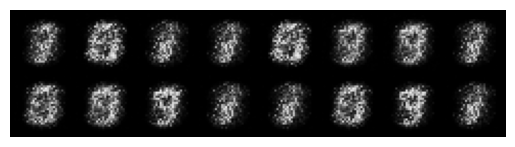

Epoch 17/200:   0%|          | 0/3 [00:00<?, ?it/s]

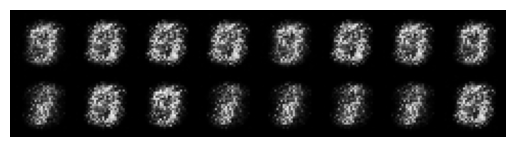

Epoch 18/200:   0%|          | 0/3 [00:00<?, ?it/s]

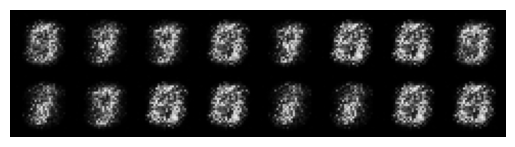

Epoch 19/200:   0%|          | 0/3 [00:00<?, ?it/s]

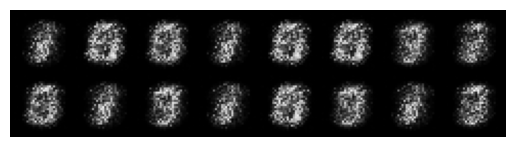

Epoch 20/200:   0%|          | 0/3 [00:00<?, ?it/s]

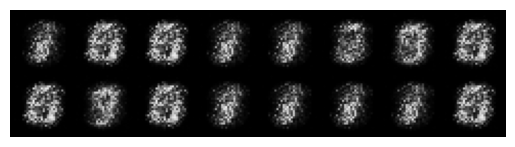

Epoch 21/200:   0%|          | 0/3 [00:00<?, ?it/s]

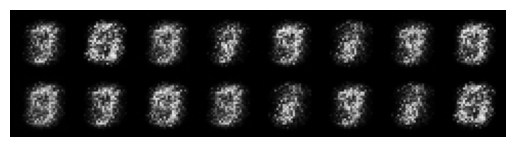

Epoch 22/200:   0%|          | 0/3 [00:00<?, ?it/s]

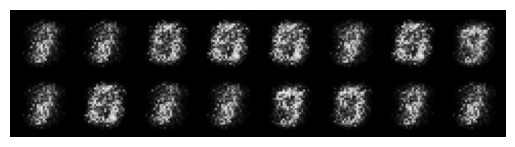

Epoch 23/200:   0%|          | 0/3 [00:00<?, ?it/s]

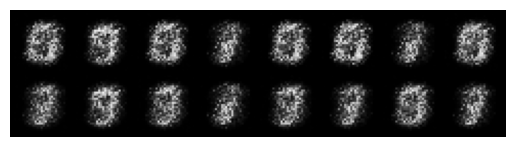

Epoch 24/200:   0%|          | 0/3 [00:00<?, ?it/s]

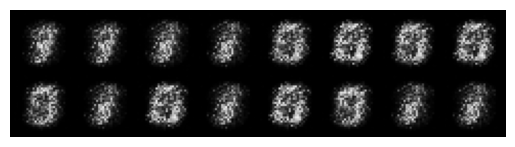

Epoch 25/200:   0%|          | 0/3 [00:00<?, ?it/s]

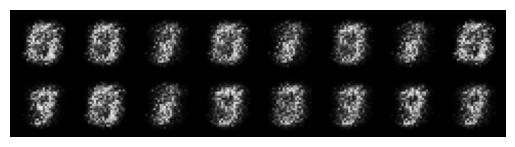

Epoch 26/200:   0%|          | 0/3 [00:00<?, ?it/s]

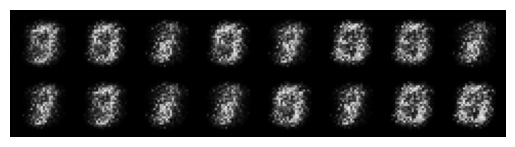

Epoch 27/200:   0%|          | 0/3 [00:00<?, ?it/s]

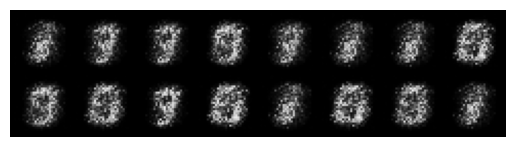

Epoch 28/200:   0%|          | 0/3 [00:00<?, ?it/s]

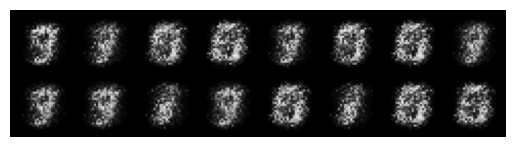

Epoch 29/200:   0%|          | 0/3 [00:00<?, ?it/s]

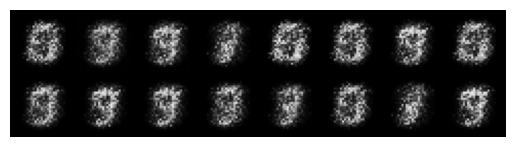

Epoch 30/200:   0%|          | 0/3 [00:00<?, ?it/s]

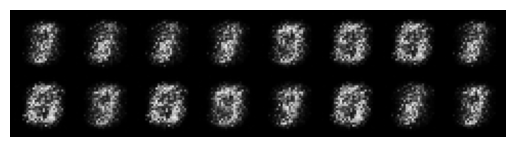

Epoch 31/200:   0%|          | 0/3 [00:00<?, ?it/s]

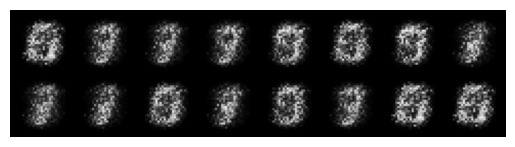

Epoch 32/200:   0%|          | 0/3 [00:00<?, ?it/s]

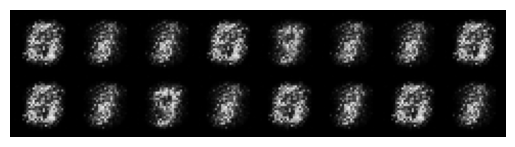

Epoch 33/200:   0%|          | 0/3 [00:00<?, ?it/s]

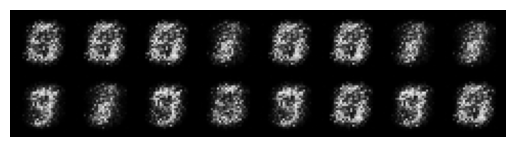

Epoch 34/200:   0%|          | 0/3 [00:00<?, ?it/s]

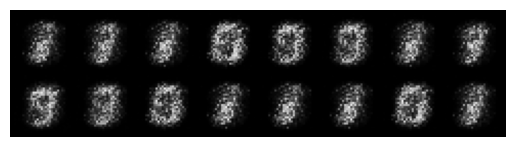

Epoch 35/200:   0%|          | 0/3 [00:00<?, ?it/s]

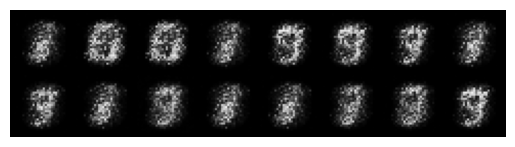

Epoch 36/200:   0%|          | 0/3 [00:00<?, ?it/s]

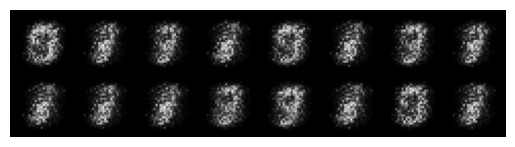

Epoch 37/200:   0%|          | 0/3 [00:00<?, ?it/s]

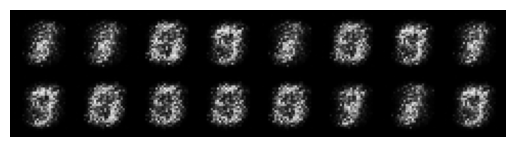

Epoch 38/200:   0%|          | 0/3 [00:00<?, ?it/s]

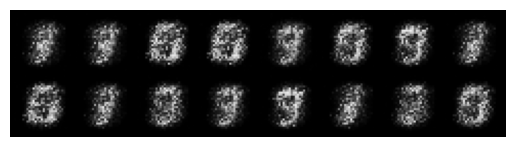

Epoch 39/200:   0%|          | 0/3 [00:00<?, ?it/s]

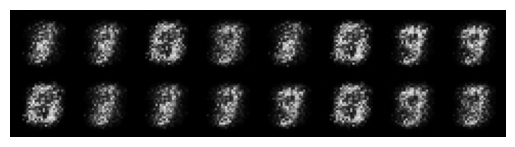

Epoch 40/200:   0%|          | 0/3 [00:00<?, ?it/s]

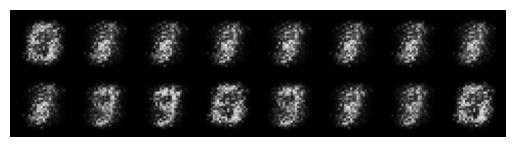

Epoch 41/200:   0%|          | 0/3 [00:00<?, ?it/s]

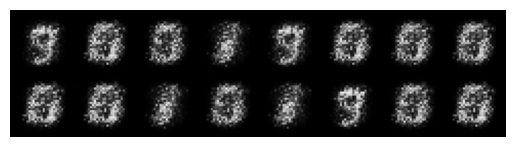

Epoch 42/200:   0%|          | 0/3 [00:00<?, ?it/s]

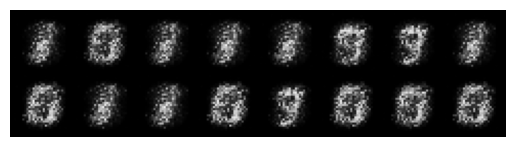

Epoch 43/200:   0%|          | 0/3 [00:00<?, ?it/s]

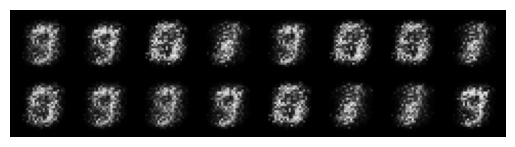

Epoch 44/200:   0%|          | 0/3 [00:00<?, ?it/s]

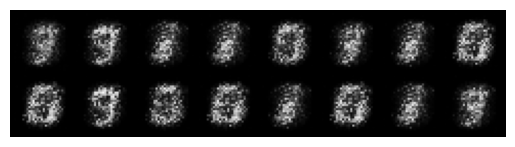

Epoch 45/200:   0%|          | 0/3 [00:00<?, ?it/s]

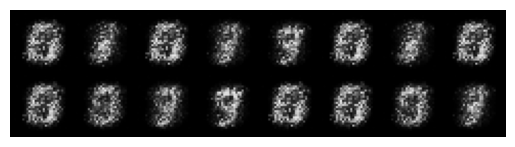

Epoch 46/200:   0%|          | 0/3 [00:00<?, ?it/s]

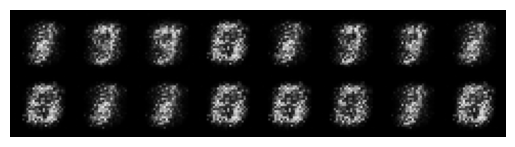

Epoch 47/200:   0%|          | 0/3 [00:00<?, ?it/s]

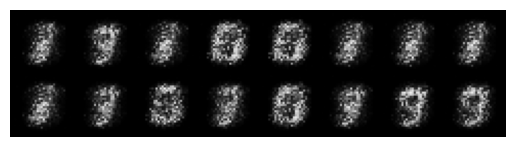

Epoch 48/200:   0%|          | 0/3 [00:00<?, ?it/s]

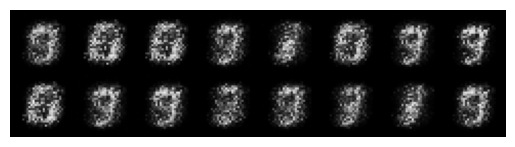

Epoch 49/200:   0%|          | 0/3 [00:00<?, ?it/s]

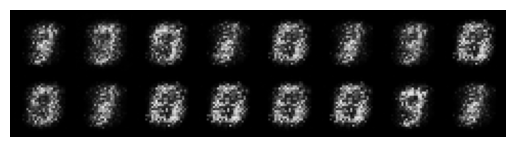

Epoch 50/200:   0%|          | 0/3 [00:00<?, ?it/s]

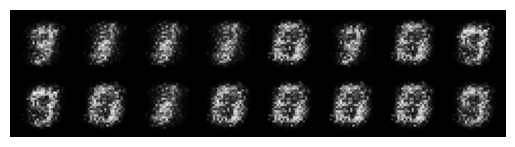

Epoch 51/200:   0%|          | 0/3 [00:00<?, ?it/s]

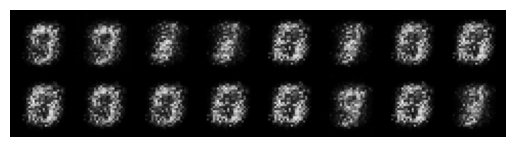

Epoch 52/200:   0%|          | 0/3 [00:00<?, ?it/s]

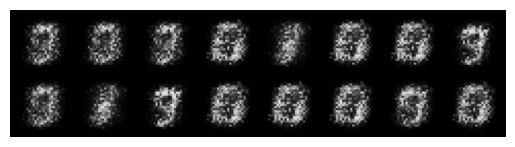

Epoch 53/200:   0%|          | 0/3 [00:00<?, ?it/s]

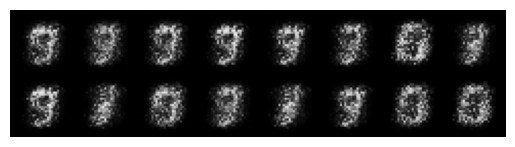

Epoch 54/200:   0%|          | 0/3 [00:00<?, ?it/s]

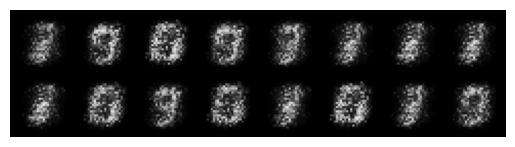

Epoch 55/200:   0%|          | 0/3 [00:00<?, ?it/s]

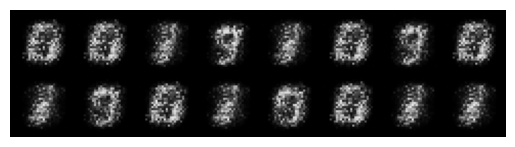

Epoch 56/200:   0%|          | 0/3 [00:00<?, ?it/s]

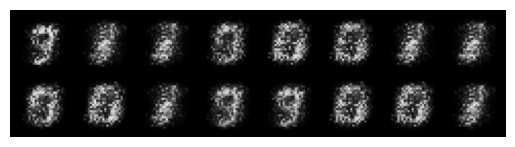

Epoch 57/200:   0%|          | 0/3 [00:00<?, ?it/s]

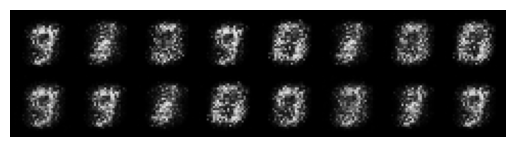

Epoch 58/200:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
num_epochs = 600
#600

for epoch in tqdm(range(num_epochs)):
    p_bar = tqdm(dataloader, desc = f'Epoch {epoch+1}/{num_epochs}: ')
    for real, _ in p_bar:
        real = rearrange(real,'b c h w -> b (c h w)').to(device)

        disc_opt.zero_grad()
        disc_loss, disc_acc = get_disc_loss(gen, disc, criterion, real, batch_size, z_dim, device)
        disc_loss.backward()
        disc_opt.step()

        gen_opt.zero_grad()
        gen_loss, gen_acc = get_gen_loss(gen, disc, criterion, batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        p_bar.set_postfix(disc_loss=disc_loss.item(), gen_loss=gen_loss.item(), disc_acc=disc_acc.item(), gen_acc=gen_acc.item())

    noise = torch.rand([batch_size, z_dim], device=device)
    fake = gen(noise)
    show_image(fake, 16)
